### All data but clean

In [280]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report

In [281]:
df = pd.read_csv('data/raw_dataset.csv')
df.shape

(4424, 35)

In [282]:
df = df[df["Target"].isin(["Dropout", "Graduate"])].copy()
print("Shape after keeping Dropout/Graduate:", df.shape)

Shape after keeping Dropout/Graduate: (3630, 35)


### Fix Previous qualification duplicate categories

In [283]:
prev_col = "Previous qualification"

prev_map = {
    15: 3,
    17: 4,
    8: 7,
    9: 7,
    10: 7,
    11: 7,
}

df[prev_col] = df[prev_col].replace(prev_map)

print("Previous qualification value counts after merge:")
print(df[prev_col].value_counts().sort_index())

Previous qualification value counts after merge:
Previous qualification
1     3019
2       22
3      156
4       13
5        1
6       15
7       57
12     149
13       6
14     164
16      28
Name: count, dtype: int64


### Group Mother's qualification and Father's qualification into 8 groups

In [284]:
m_f_qual_cols = ["Mother's qualification", "Father's qualification"]

qual_groups = [
    [1, 7, 8, 10, 11, 12, 14, 15, 17, 19, 20],         # group 1
    [25, 26],                                          # group 2
    [9, 18, 21, 27, 28],                               # group 3
    [6, 13, 16, 22, 23, 29, 31, 32],                   # group 4
    [2, 3, 30],                                        # group 5
    [4, 33],                                           # group 6
    [5, 34],                                           # group 7
    [24],                                              # group 8
]

def build_group_map(groups):
    mapping = {}
    for i, group in enumerate(groups, start=1):
        for code in group:
            mapping[code] = i   # map all codes in that list to group i
    return mapping

qual_map = build_group_map(qual_groups)

for col in m_f_qual_cols:
    df[col] = df[col].replace(qual_map)

print("\nMother's qualification value counts after grouping:")
print(df["Mother's qualification"].value_counts().sort_index())
print("\nFather's qualification value counts after grouping:")
print(df["Father's qualification"].value_counts().sort_index())


Mother's qualification value counts after grouping:
Mother's qualification
1    1053
2      14
3      16
4    2094
5     397
6      34
7      16
8       6
Name: count, dtype: int64

Father's qualification value counts after grouping:
Father's qualification
1    1569
2      10
3    1600
4      24
5     268
6      34
7      16
8     109
Name: count, dtype: int64


### Keep only Portuguese students (Nationality == 1)

In [285]:
nat_col = "Nacionality"
df = df[df[nat_col] == 1].copy()

print("\nShape after keeping only Nationality == 1 (Portugal):", df.shape)
print("Nationality value counts:")
print(df[nat_col].value_counts())


Shape after keeping only Nationality == 1 (Portugal): (3544, 35)
Nationality value counts:
Nacionality
1    3544
Name: count, dtype: int64


### Group Mother's occupation and Father's occupation into 8 groups

In [286]:
m_f_occ_cols = ["Mother's occupation", "Father's occupation"]

occ_groups = [
    [2, 17, 18, 14, 15, 16],                           # group 1
    [3, 19, 20, 21, 22],                               # group 2
    [4, 23, 24, 25, 26],                               # group 3
    [5, 27, 28, 29],                                   # group 4
    [6, 30, 31, 32, 33],                               # group 5
    [7, 34, 35, 43],                                   # group 6
    [8, 36, 37, 38, 39, 40, 41, 42, 44],               # group 7
    [1, 10, 11, 12, 13, 45, 46],                       # group 8
]

occ_map = build_group_map(occ_groups)

for col in m_f_occ_cols:
    df[col] = df[col].replace(occ_map)

print("\nMother's occupation value counts after grouping:")
print(df["Mother's occupation"].value_counts().sort_index())
print("\nFather's occupation value counts after grouping:")
print(df["Father's occupation"].value_counts().sort_index())


Mother's occupation value counts after grouping:
Mother's occupation
1      92
2     241
3     270
4     677
5     440
6      74
7     223
8    1498
9      29
Name: count, dtype: int64

Father's occupation value counts after grouping:
Father's occupation
1     115
2     149
3     317
4     313
5     406
6     191
7     563
8    1234
9     256
Name: count, dtype: int64


### Remove Nal first year

In [287]:
first_year_cols = [
    "Curricular units 1st sem (credited)",
    "Curricular units 1st sem (enrolled)",
    "Curricular units 1st sem (evaluations)",
    "Curricular units 1st sem (approved)",
    "Curricular units 1st sem (grade)",
    "Curricular units 1st sem (without evaluations)",
    "Curricular units 2nd sem (credited)",
    "Curricular units 2nd sem (enrolled)",
    "Curricular units 2nd sem (evaluations)",
    "Curricular units 2nd sem (approved)",
    "Curricular units 2nd sem (grade)",
    "Curricular units 2nd sem (without evaluations)"
]
df[first_year_cols] = df[first_year_cols].apply(pd.to_numeric, errors="coerce")
mask_all_zero = (df[first_year_cols] == 0).all(axis=1)

df = df[~mask_all_zero].copy()

print("Shape after removing NAL observations:", df.shape)
print("Removed rows:", mask_all_zero.sum())

Shape after removing NAL observations: (3398, 35)
Removed rows: 146


In [288]:
cols_to_drop = [c for c in df.columns if 'Curricular units' in c]
print(f"Dropping academic history columns: {cols_to_drop}")

Dropping academic history columns: ['Curricular units 1st sem (credited)', 'Curricular units 1st sem (enrolled)', 'Curricular units 1st sem (evaluations)', 'Curricular units 1st sem (approved)', 'Curricular units 1st sem (grade)', 'Curricular units 1st sem (without evaluations)', 'Curricular units 2nd sem (credited)', 'Curricular units 2nd sem (enrolled)', 'Curricular units 2nd sem (evaluations)', 'Curricular units 2nd sem (approved)', 'Curricular units 2nd sem (grade)', 'Curricular units 2nd sem (without evaluations)']


In [289]:
df = df.drop(columns=cols_to_drop).copy()

### Now we have cleand data

In [290]:
print("Cleaned data shape:", df.shape)
print("Target distribution:\n", df["Target"].value_counts())


Cleaned data shape: (3398, 23)
Target distribution:
 Target
Graduate    2082
Dropout     1316
Name: count, dtype: int64


In [291]:
numeric_cols = [
    "Unemployment rate",
    "Inflation rate",
    "GDP",
]

all_feature_cols = [c for c in df.columns if c != "Target"]

categorical_cols = [c for c in all_feature_cols if c not in numeric_cols]

In [292]:
df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors="coerce")
for col in categorical_cols:
    df[col] = df[col].astype("category")

df = df.dropna(subset=numeric_cols)


In [293]:
df["y"] = (df["Target"] == "Dropout").astype(int)

X = df[all_feature_cols]
y = df["y"]


In [294]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


In [295]:
preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols),
    ]
)

In [296]:
log_reg = LogisticRegression(
    max_iter=2000,
    # class_weight="balanced"  # uncomment if dropout is very imbalanced
)

rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    min_samples_split=4,
    random_state=42,
    n_jobs=-1
)

xgb = XGBClassifier(
    n_estimators=400,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="logloss",
    random_state=42,
    n_jobs=-1
)

pipe_log = Pipeline([("prep", preprocess), ("model", log_reg)])
pipe_rf  = Pipeline([("prep", preprocess), ("model", rf)])
pipe_xgb = Pipeline([("prep", preprocess), ("model", xgb)])

In [297]:
pipe_log.fit(X_train, y_train)
pipe_rf.fit(X_train, y_train)
pipe_xgb.fit(X_train, y_train)

,steps,"[('prep', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True



Logistic Regression results
Accuracy: 0.778
AUC: 0.839
Confusion Matrix:
 [[365  52]
 [ 99 164]]

Classification report:
               precision    recall  f1-score   support

           0       0.79      0.88      0.83       417
           1       0.76      0.62      0.68       263

    accuracy                           0.78       680
   macro avg       0.77      0.75      0.76       680
weighted avg       0.78      0.78      0.77       680



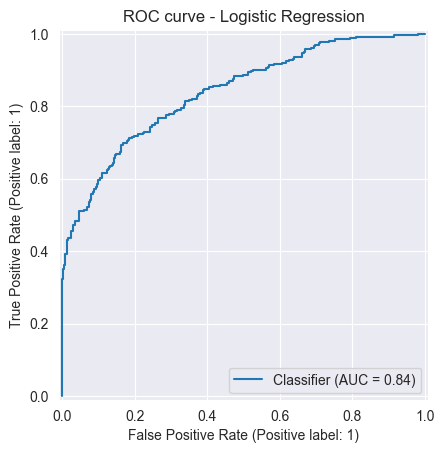


Random Forest results
Accuracy: 0.782
AUC: 0.847
Confusion Matrix:
 [[369  48]
 [100 163]]

Classification report:
               precision    recall  f1-score   support

           0       0.79      0.88      0.83       417
           1       0.77      0.62      0.69       263

    accuracy                           0.78       680
   macro avg       0.78      0.75      0.76       680
weighted avg       0.78      0.78      0.78       680



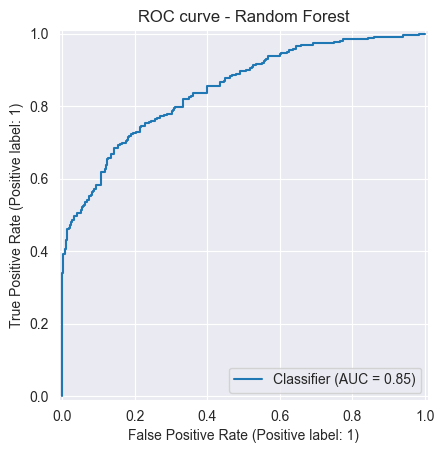


XGBoost results
Accuracy: 0.76
AUC: 0.838
Confusion Matrix:
 [[348  69]
 [ 94 169]]

Classification report:
               precision    recall  f1-score   support

           0       0.79      0.83      0.81       417
           1       0.71      0.64      0.67       263

    accuracy                           0.76       680
   macro avg       0.75      0.74      0.74       680
weighted avg       0.76      0.76      0.76       680



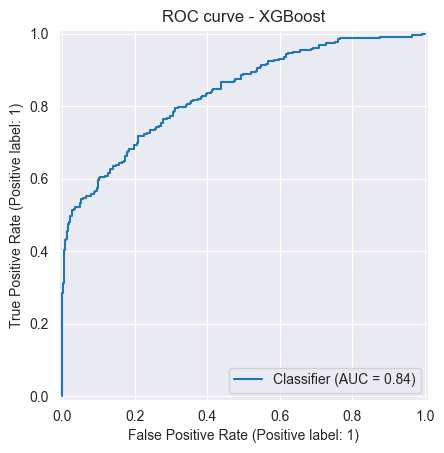

In [298]:
from sklearn.metrics import RocCurveDisplay
import matplotlib.pyplot as plt

def evaluate(model, name):
    print("\n" + "="*70)
    print(f"{name} results")
    print("="*70)

    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_proba)
    cm = confusion_matrix(y_test, y_pred)

    print("Accuracy:", round(acc, 3))
    print("AUC:", round(auc, 3))
    print("Confusion Matrix:\n", cm)
    print("\nClassification report:\n", classification_report(y_test, y_pred))

    # optional: ROC curve
    RocCurveDisplay.from_predictions(y_test, y_proba)
    plt.title(f"ROC curve - {name}")
    plt.show()

evaluate(pipe_log, "Logistic Regression")
evaluate(pipe_rf,  "Random Forest")
evaluate(pipe_xgb, "XGBoost")

### feature importance of the XGBoost model

In [299]:
xgb_model = pipe_xgb.named_steps["model"]

In [300]:
# Fit preprocessing on train data if not yet fitted
preprocess.fit(X_train)

ohe = preprocess.named_transformers_["cat"]
encoded_cat_names = list(ohe.get_feature_names_out(categorical_cols))

feature_names = numeric_cols + encoded_cat_names

In [301]:
booster = xgb_model.get_booster()
importance_dict = booster.get_score(importance_type='gain')

In [302]:
importance_df = pd.DataFrame([
    (feature_names[int(k[1:])], v)
    for k, v in importance_dict.items()
], columns=["feature", "gain_importance"])

importance_df = importance_df.sort_values("gain_importance", ascending=False)
print(importance_df.head(20))

                       feature  gain_importance
86   Tuition fees up to date_1        60.305378
85   Tuition fees up to date_0        39.618713
90        Scholarship holder_1        13.503224
89        Scholarship holder_0        11.443615
33                   Course_12         6.008922
28                    Course_7         5.989612
83                    Debtor_0         5.820383
11         Application mode_12         5.813299
37                   Course_16         5.075055
7           Application mode_1         4.758739
60    Father's qualification_8         4.573216
87                    Gender_0         3.791235
84                    Debtor_1         3.706398
88                    Gender_1         3.596274
8           Application mode_4         3.175936
103       Age at enrollment_30         3.056071
32                   Course_11         3.018685
25                    Course_4         2.877926
30                    Course_9         2.856243
29                    Course_8         2

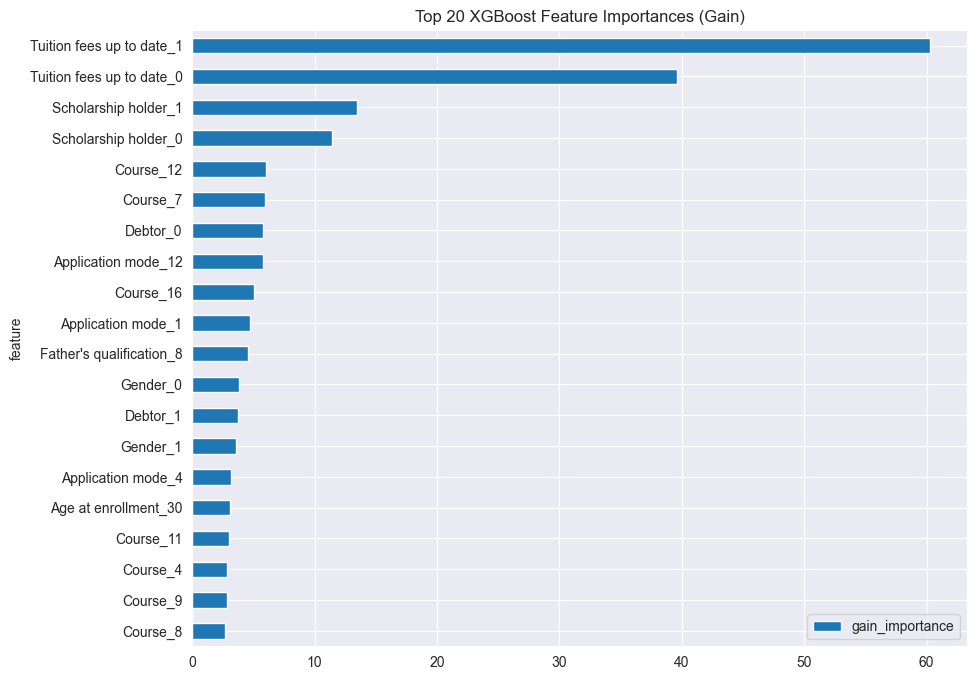

In [303]:
importance_df.head(20).plot(
    x='feature',
    y='gain_importance',
    kind='barh',
    figsize=(10,8)
)
plt.title("Top 20 XGBoost Feature Importances (Gain)")
plt.gca().invert_yaxis()
plt.show()

### Getting importance at the variable level (not each dummy)

In [304]:
# importance_df has columns: ["feature", "gain_importance"]

# base feature name = everything before the last underscore
importance_df["base_feature"] = importance_df["feature"].str.replace(r"_[^_]+$", "", regex=True)

# For numeric features (no underscore at the end) this leaves them as-is.

# Sum gain importance over all dummies of the same original feature
grouped_importance = (
    importance_df
    .groupby("base_feature")["gain_importance"]
    .sum()
    .sort_values(ascending=False)
)

print(grouped_importance.head(20))

base_feature
Tuition fees up to date       99.924091
Age at enrollment             49.078747
Course                        46.296268
Scholarship holder            24.946839
Application mode              24.891849
Mother's occupation           16.139284
Father's occupation           15.833771
Father's qualification        13.533067
Previous qualification        12.296794
Application order             11.199893
Debtor                         9.526781
Mother's qualification         7.844151
Gender                         7.387509
Marital status                 6.231946
Educational special needs      3.973147
Displaced                      3.490511
Daytime/evening attendance     2.857370
GDP                            1.954292
Inflation rate                 1.929588
Unemployment rate              1.699412
Name: gain_importance, dtype: float64


### We want to understand how in the three models we got a very high AUC (0.83-4) and all this with data without first year .


# -------------------------------------------------

#### Tuition fees: The most divisive statistic

In [305]:
# Tuition fees up to date)
# 1 = paid on time , 0 = didnt paid on time
print("--- 1. Tuition Fees Analysis ---")
tuition_stats = df.groupby('Target')['Tuition fees up to date'].value_counts(normalize=True).unstack()
print(tuition_stats)

dropouts_unpaid = tuition_stats.loc['Dropout', 0] * 100
graduates_paid = tuition_stats.loc['Graduate', 1] * 100
print(f"\nDropouts who didn't pay: {dropouts_unpaid:.1f}%")
print(f"Graduates who paid on time: {graduates_paid:.1f}%")

--- 1. Tuition Fees Analysis ---
Tuition fees up to date         0         1
Target                                     
Dropout                  0.320669  0.679331
Graduate                 0.009126  0.990874

Dropouts who didn't pay: 32.1%
Graduates who paid on time: 99.1%


#### Among graduates: Almost 99% paid their tuition on time.
#### Among dropouts: About 32% did not pay.
#### The Meaning is that once a student does not pay their tuition, the model knows with almost absolute certainty (99%) that they will not complete their degree. This is as strong a signal as a failing grade.

# --------------------------------



### Age at Enrollment: Younger people survive longer

In [306]:
print("--- 2. Age Analysis ---")
df['Age at enrollment'] = pd.to_numeric(df['Age at enrollment'], errors='coerce')
age_stats = df.groupby('Target')['Age at enrollment'].agg(['mean', 'std', 'min', 'max'])
print(age_stats)
avg_age_dropout = age_stats.loc['Dropout', 'mean']
avg_age_graduate = age_stats.loc['Graduate', 'mean']

print(f"\nAverage Age - Dropouts: {avg_age_dropout:.1f}")
print(f"Average Age - Graduates: {avg_age_graduate:.1f}")
print(f"Gap: {avg_age_dropout - avg_age_graduate:.1f} years")

--- 2. Age Analysis ---
               mean       std  min  max
Target                                 
Dropout   26.356383  8.802776   18   70
Graduate  21.867435  6.793212   17   62

Average Age - Dropouts: 26.4
Average Age - Graduates: 21.9
Gap: 4.5 years


#### A gap of almost 4.5 years is very statistically significant. Older students probably come with more commitments (work, family) Or they weren't good enough to be accepted into regular admissions at the usual age, and are therefore at higher risk.

#### We can see that also at  the application mode: The model sees students admitted through the "over 23" section (status 12) dropping out at a rate of 65%, compared to regular students.

# --------------------------------------------------------

### Scholarship: Safety Net

In [307]:
print("--- 3. Scholarship Analysis ---")
scholarship_stats = df.groupby('Target')['Scholarship holder'].value_counts(normalize=True).unstack()
print(scholarship_stats)

scholarship_dropouts = scholarship_stats.loc['Dropout', 1] * 100
scholarship_graduates = scholarship_stats.loc['Graduate', 1] * 100
print(f"\nDropouts with scholarship: {scholarship_dropouts:.1f}%")
print(f"Graduates with scholarship: {scholarship_graduates:.1f}%")

--- 3. Scholarship Analysis ---
Scholarship holder         0         1
Target                                
Dropout             0.908055  0.091945
Graduate            0.618636  0.381364

Dropouts with scholarship: 9.2%
Graduates with scholarship: 38.1%


#### Only 9.4% of dropouts received a scholarship.
#### In contrast, 38.1% of graduates were scholarship recipients.
#### Receiving a scholarship is a double positive indicator: both financial relief and (usually) an indication of prior academic potential or a socioeconomic background that the university supports.

# -------------------------------------------

#### There are "hard" courses with high natural dropout rates, and there are "easy" or more supportive courses. For example, in courses 1 and 7 (Biofuel Production / Informatics Engineering) the dropout rate is insane (87.5%). In contrast, in course 12 (Nursing) the dropout rate is only 17%. The model learns this and understands that if you enroll in nursing, your chances of surviving are higher than if you enroll in software engineering.

In [308]:
import pandas as pd

df = pd.read_csv('data/raw_dataset.csv')
df = df[df['Target'].isin(['Dropout', 'Graduate'])]
df = df[df['Nacionality'] == 1]

course_names = pd.read_csv('categories/tA4_course_names.csv')

course_stats = df.groupby('Course')['Target'].value_counts(normalize=True).unstack(fill_value=0)

analysis = course_names.merge(course_stats, left_on='ID', right_index=True)

analysis['Dropout_Rate'] = analysis['Dropout'] * 100
analysis = analysis[['ID', 'Course_Name', 'Dropout_Rate']].sort_values('Dropout_Rate', ascending=False)

print("--- Course Dropout Analysis ---")

print("\nTop 5 Highest Dropout Courses:")
print(analysis.head(5).to_string(index=False))

print("\nTop 5 Lowest Dropout Courses:")
print(analysis.tail(5).to_string(index=False))


--- Course Dropout Analysis ---

Top 5 Highest Dropout Courses:
 ID                     Course_Name  Dropout_Rate
  1 Biofuel Production Technologies     87.500000
  7         Informatics Engineering     87.500000
  8                   Equiniculture     64.347826
 17 Management (evening attendance)     63.679245
 16                 Basic Education     60.000000

Top 5 Lowest Dropout Courses:
 ID                  Course_Name  Dropout_Rate
  6           Veterinary Nursing     35.177866
 15 Journalism and Communication     33.928571
  5         Communication Design     28.021978
 10               Social Service     21.241830
 12                      Nursing     17.397882


# Error Analysis